<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/dcgan_overriding_train_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 32x32.

In [ ]:
! mkdir celeba_gan
#os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

mkdir: cannot create directory ‘celeba_gan’: File exists


Create a dataset from our folder, and rescale the images to the [0-1] range:

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(32, 32), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files belonging to 1 classes.


Let's display a sample image:

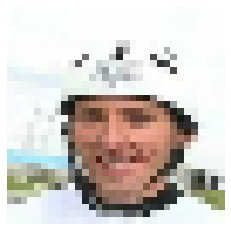

In [ ]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 32x32 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              532480    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 512)       20

## Override `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        fig = plt.figure(figsize=(20, 4))  # figure size in inches
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

            ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
            ax.imshow(img)

        fig.show()



## Train the end-to-end model

<MapDataset shapes: (None, 32, 32, 3), types: tf.float32>
Epoch 1/20
6332/6332 [==============================] - 1161s 183ms/step - d_loss: 0.6459 - g_loss: 0.9864
Epoch 2/20
6332/6332 [==============================] - 1154s 182ms/step - d_loss: 0.6888 - g_loss: 0.8304
Epoch 3/20
6332/6332 [==============================] - 1146s 181ms/step - d_loss: 0.6928 - g_loss: 0.8179
Epoch 4/20
6332/6332 [==============================] - 1146s 181ms/step - d_loss: 0.6956 - g_loss: 0.8173
Epoch 5/20
6332/6332 [==============================] - 1153s 182ms/step - d_loss: 0.6928 - g_loss: 0.8204
Epoch 6/20
6332/6332 [==============================] - 1154s 182ms/step - d_loss: 0.6924 - g_loss: 0.8308
Epoch 7/20
6332/6332 [==============================] - 1141s 180ms/step - d_loss: 0.6844 - g_loss: 0.8572
Epoch 8/20
6332/6332 [==============================] - 1139s 180ms/step - d_loss: 0.6914 - g_loss: 0.8375
Epoch 9/20
6332/6332 [==============================] - 1147s 181ms/step - d_loss: 0.6

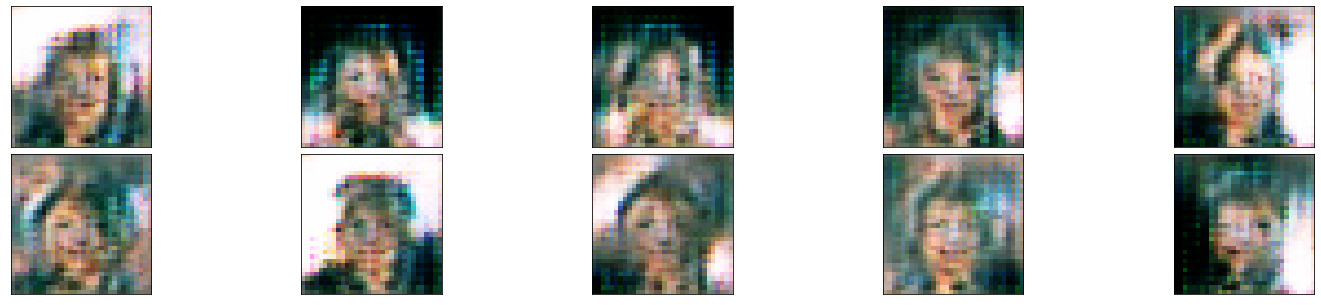

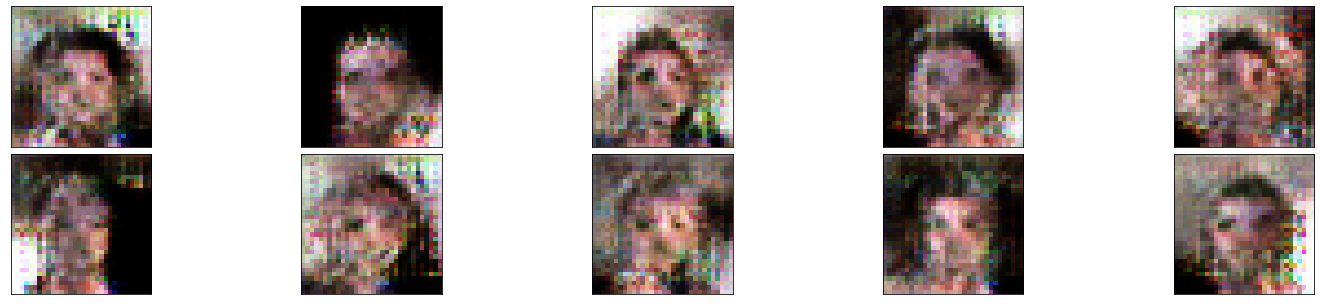

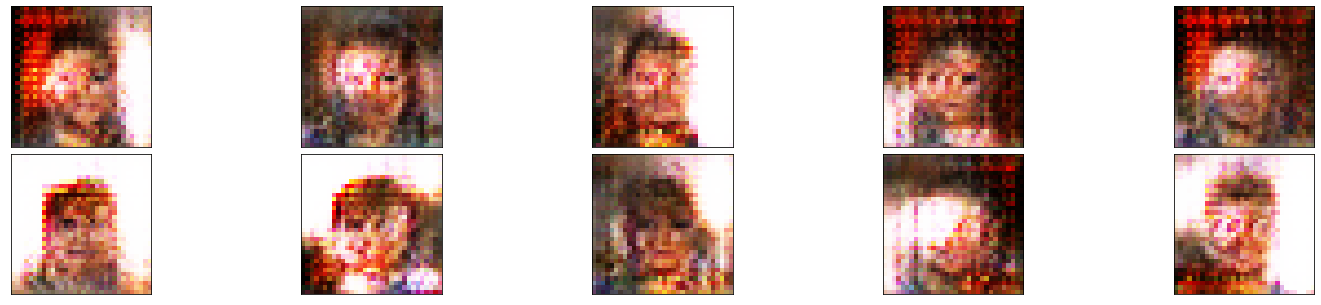

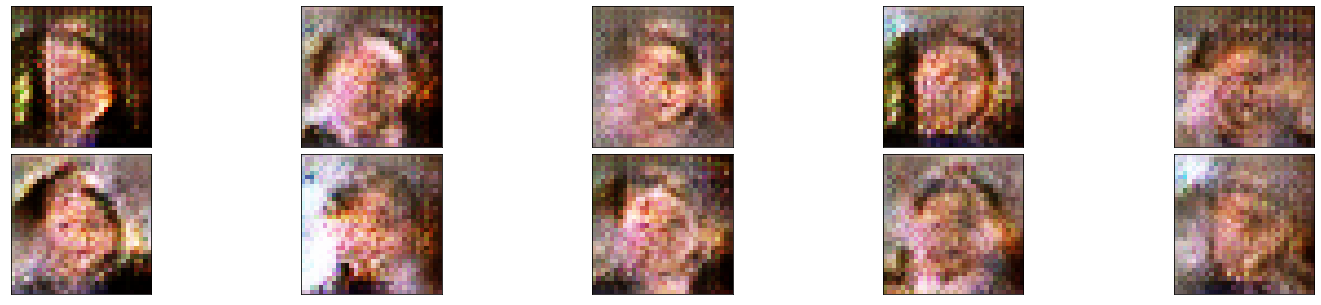

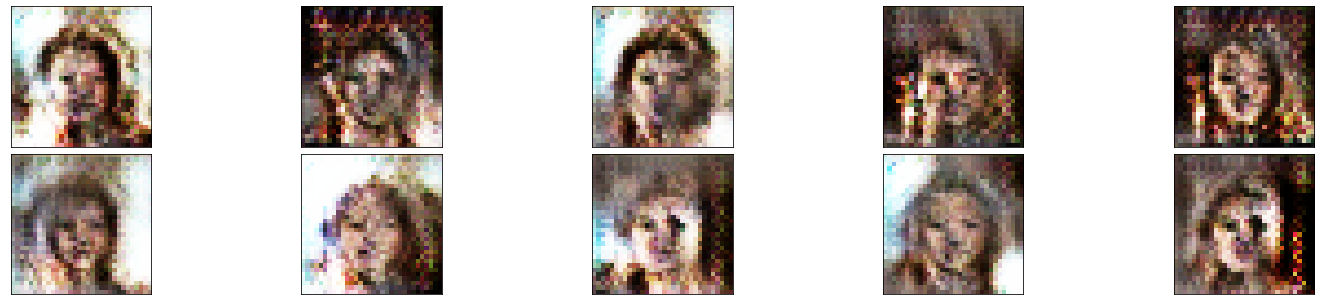

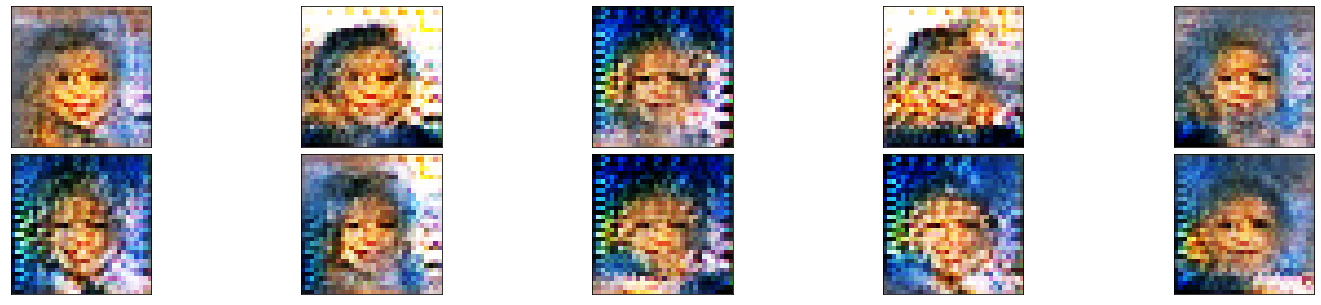

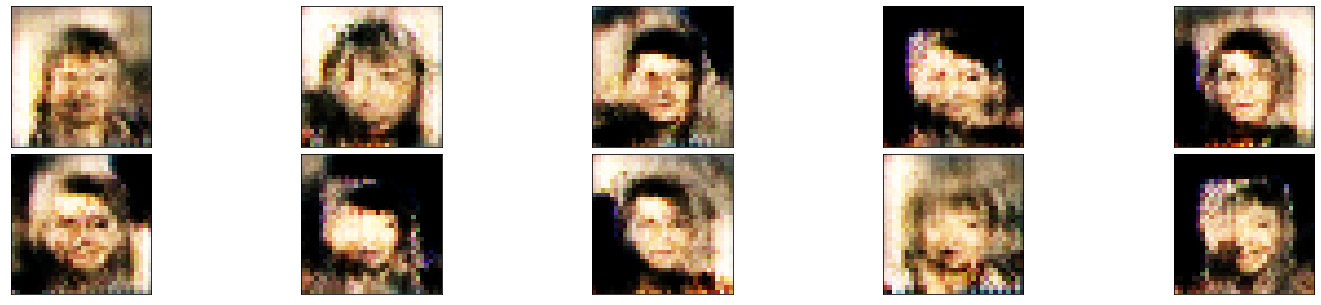

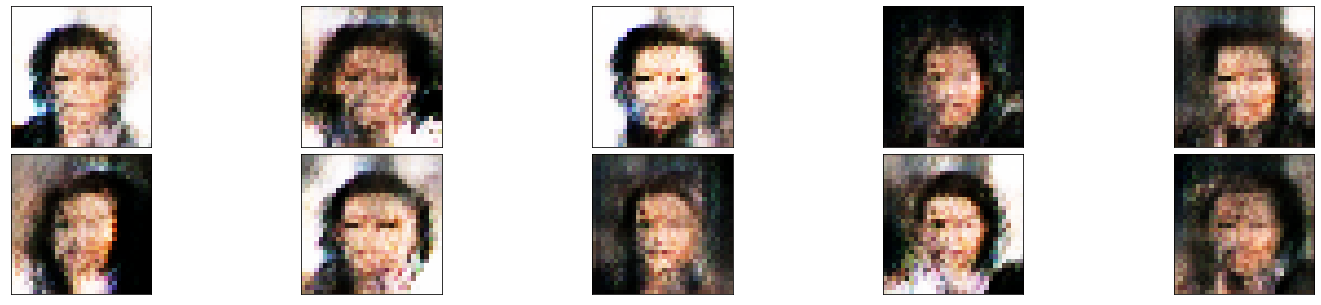

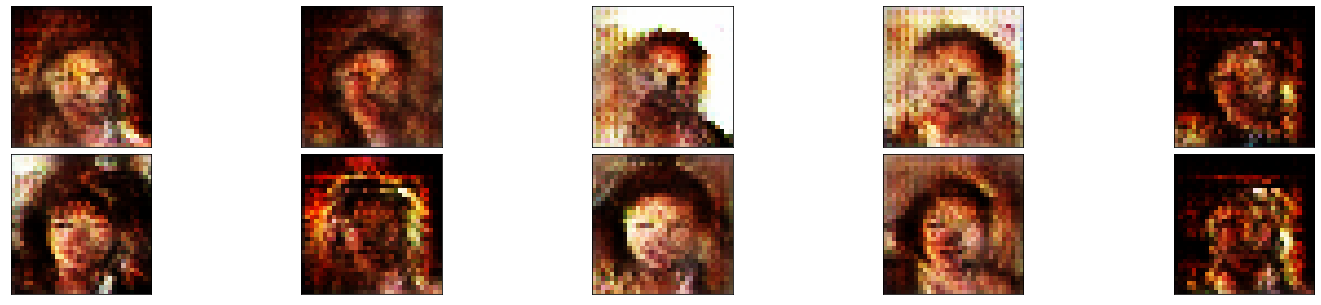

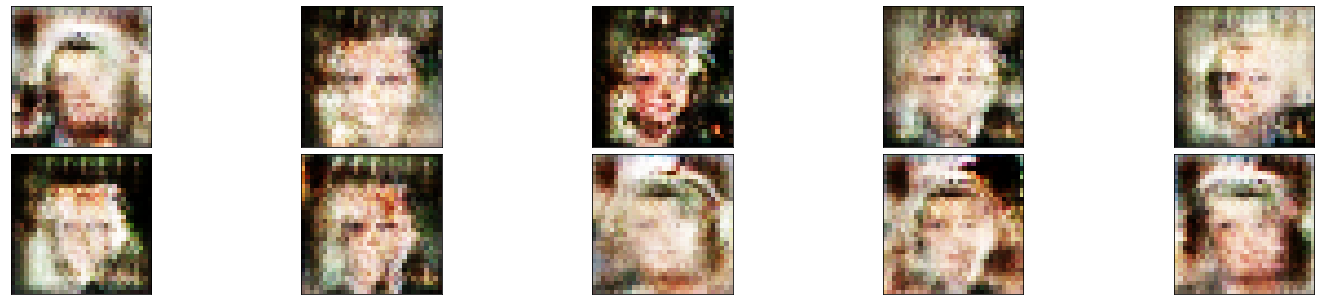

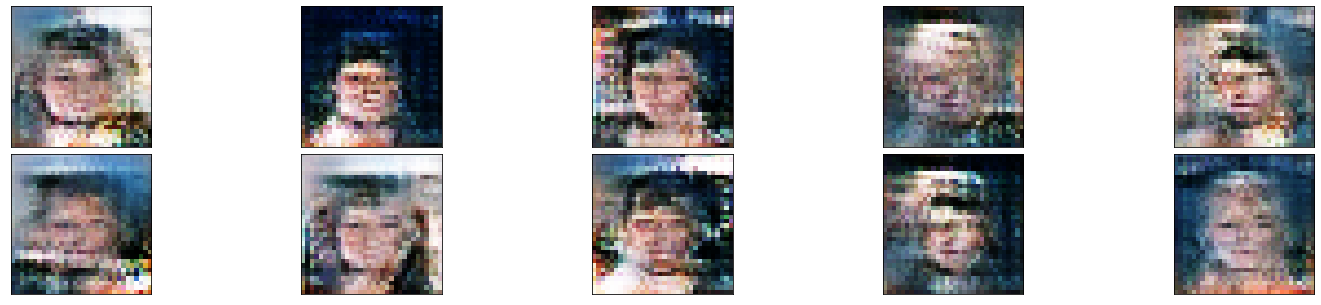

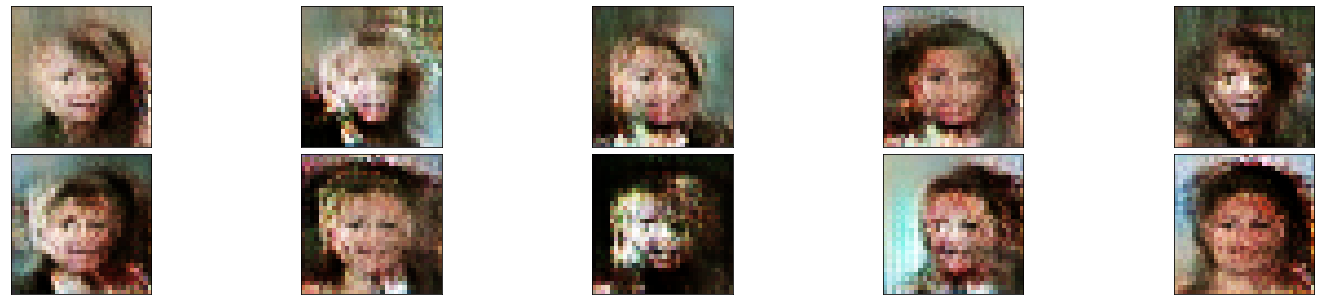

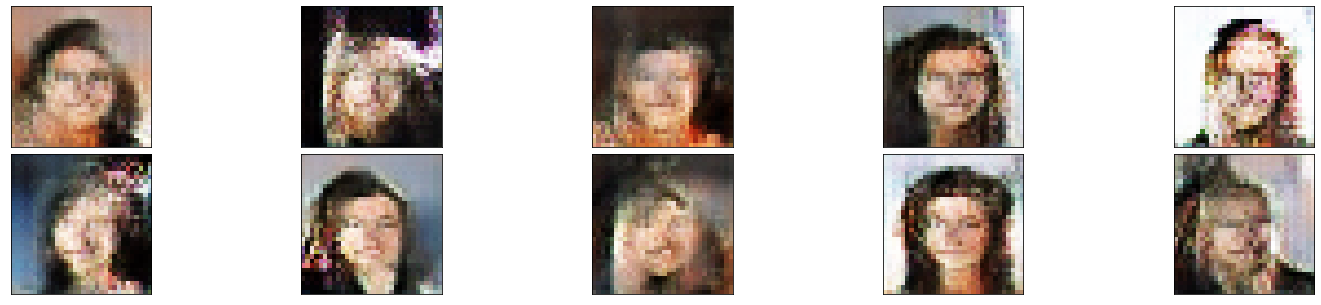

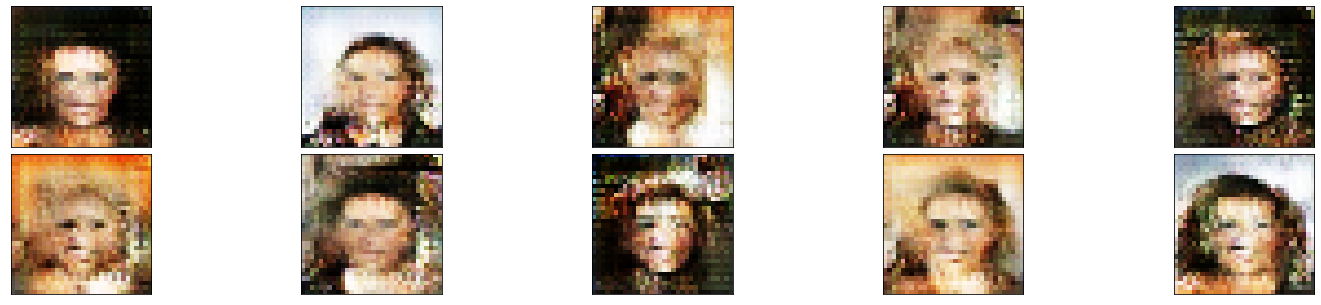

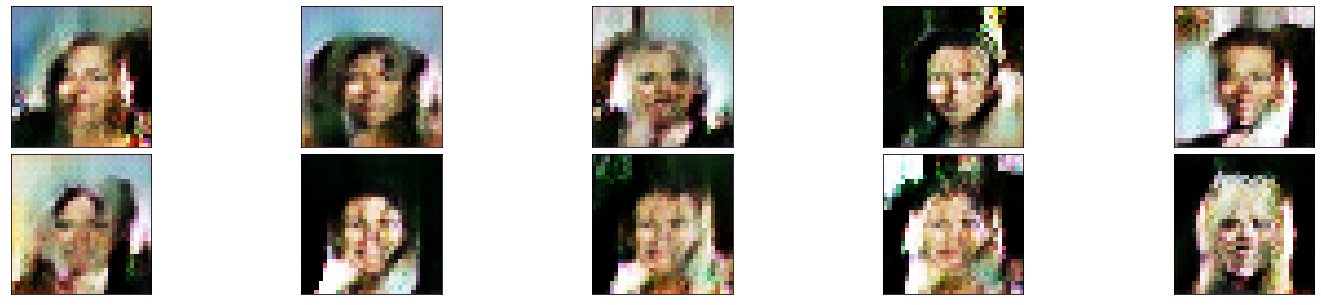

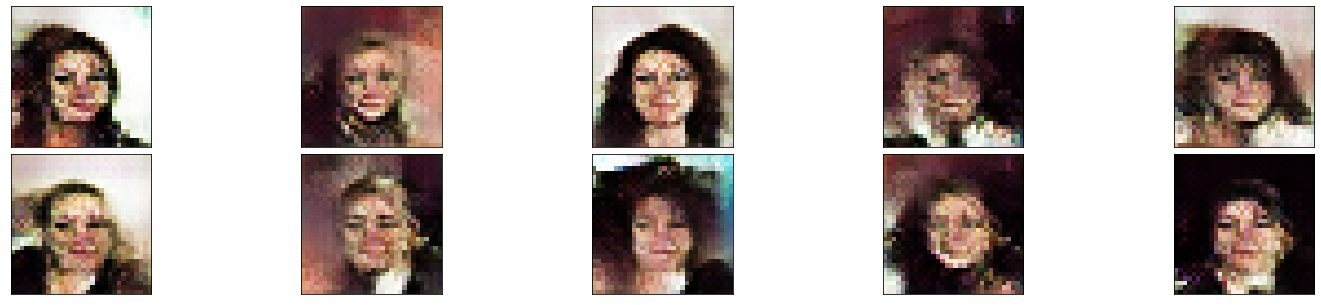

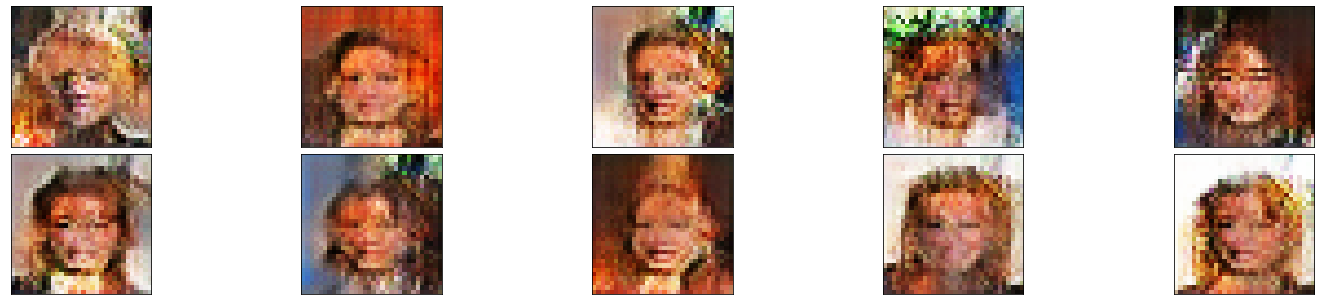

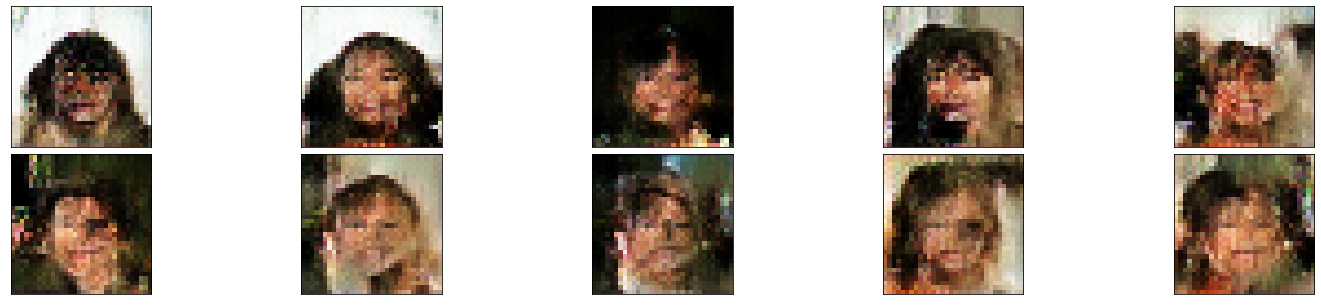

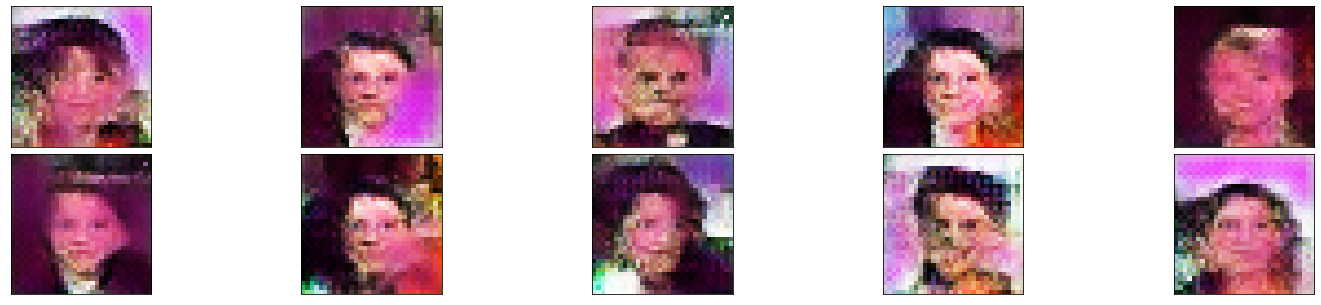

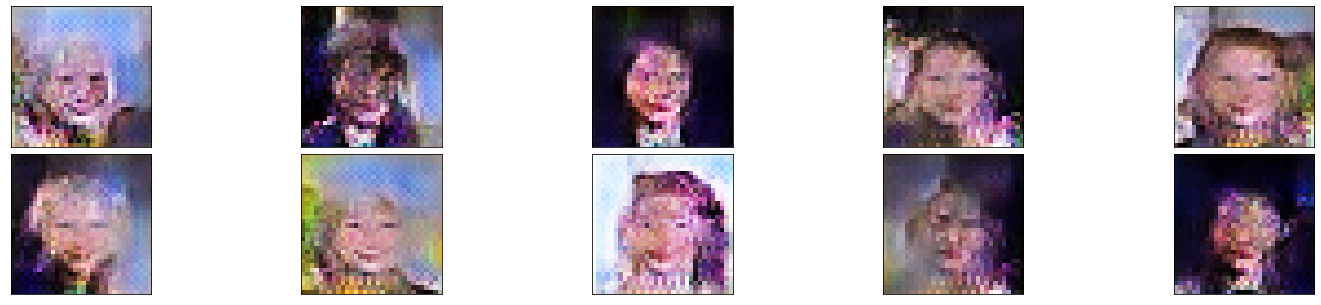

In [ ]:
epochs = 20  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

print(dataset)
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
